In [1]:
# Tensorflow and keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, ZeroPadding2D, concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, AveragePooling2D
from tensorflow.keras import backend as K

# Helper Libraries
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Importing the Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
print("""Training Data Shape: {}
Test Data Shape: {}""".format(x_train.shape, x_test.shape))

Training Data Shape: (60000, 28, 28)
Test Data Shape: (10000, 28, 28)


### Normalising

In [4]:
# x_train = x_train/255
# x_test = x_test/255
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)/255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)/255
print("""NEW Training Data Shape: {}
# NEW Test Data Shape: {}""".format(x_train.shape, x_test.shape))

NEW Training Data Shape: (60000, 28, 28, 1)
# NEW Test Data Shape: (10000, 28, 28, 1)


### Plot Examples

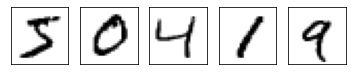

In [5]:
def plot_images(examples):
  max_ele_rows = 5
  r = int(np.ceil(len(examples)/max_ele_rows))
  c = min(len(examples), max_ele_rows)
  plt.figure(figsize=(6,2))
  k = 0
  for i in range(r):
    for j in range(c):
      plt.subplot(r, c, k+1)
      plt.imshow(np.reshape(examples[k],(28, 28)), cmap='binary')
      plt.xticks([])
      plt.yticks([])
      k+=1
  plt.show()

# Ploting few images of dataset
plot_images(x_train[:5])

### Creating Batch of Triplets

In [6]:
def create_batch(batch_size=256):
  img_dim = (x_train.shape[1], x_train.shape[2], 1)
  x_anchors = np.zeros((batch_size, *img_dim))
  x_positives = np.zeros((batch_size, *img_dim))
  x_negatives = np.zeros((batch_size, *img_dim))
  indices = []
  for i in range(batch_size):
    while True:
      random_index = random.randint(0, x_train.shape[0]-1)
      if random_index not in indices:
        break
    x_anchor = x_train[random_index]
    y = y_train[random_index]

    x_positive = x_train[np.random.choice(np.squeeze(np.where(y_train==y)))]
    x_negative = x_train[np.random.choice(np.squeeze(np.where(y_train!=y)))]

    x_anchors[i] = x_anchor
    x_positives[i] = x_positive
    x_negatives[i] = x_negative
    
    indices.append(random_index)
  return [x_anchors, x_positives, x_negatives]

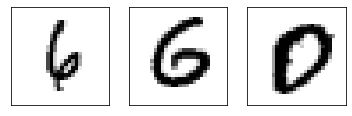

In [7]:
examples = create_batch(1)
plot_images(examples)

### Embeddings Model

#### Generally, multiple layers of INCEPTION is recommended for embeddings. Just for the sake of understanding, I'm using very few layers to generate embeddings.

In [8]:
emb_size = 128

def simple_model(input_shape):

  # Defining tensor with the input shape
  X_input = Input(shape=input_shape)

  # Zero-padding
  X = ZeroPadding2D(padding=(1, 1))(X_input)

  # Convolution Block
  X = Conv2D(64, (7,7), strides=(2, 2), name='Conv1')(X)
  X = BatchNormalization(name = 'bn1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D(pool_size=3, strides=2)(X)

  # Top Layer
  X = Flatten()(X)
  X = Dense(64, activation='relu')(X)
  X = Dense(emb_size)(X)

  # Defining Model
  emb_model   = Model(inputs = X_input, outputs = X, name='simple_facenet')
  # Model Summary
  emb_model.summary()
  
  return emb_model

def inception_block(X):
  X_pad = ZeroPadding2D(padding=(1,1))(X)
  
  X_3x3 = Conv2D(64, (1, 1), name = '3x3_Conv1')(X)
  X_3x3 = BatchNormalization(epsilon=0.00001)(X_3x3)
  X_3x3 = Activation('relu')(X_3x3)
  X_3x3 = ZeroPadding2D(padding=(1,1))(X_3x3)
  X_3x3 = Conv2D(emb_size, (3, 3), name = '3x3_Conv2')(X_3x3)
  X_3x3 = BatchNormalization(epsilon=0.00001)(X_3x3)
  X_3x3 = Activation('relu')(X_3x3)

  X_5x5 = Conv2D(16, (1,1), name='5x5_Conv1')(X)
  X_5x5 = BatchNormalization(epsilon=0.00001)(X_5x5)
  X_5x5 = Activation('relu')(X_5x5)
  X_5x5 = ZeroPadding2D(padding=(2,2))(X_5x5)
  X_5x5 = Conv2D(32, (5, 5), name='5x5_Conv2')(X_5x5)
  X_5x5 = BatchNormalization(epsilon=0.00001)(X_5x5)
  X_5x5 = Activation('relu')(X_5x5)

  X_pool = MaxPooling2D(pool_size=3, strides=1)(X_pad)
  X_pool = Conv2D(32, (1,1))(X_pool)
  X_pool = BatchNormalization(epsilon=0.00001)(X_pool)
  X_pool = Activation('relu')(X_pool)

  X_1x1 = Conv2D(64, (1, 1))(X)
  X_1x1 = BatchNormalization(epsilon=0.00001)(X_1x1)
  X_1x1 = Activation('relu')(X_1x1)

  # Concatenate
  inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=-1)
  
  return inception

def facenet_model(input_shape):
  
  # Defining tensor with the input shape
  X_input = Input(shape=input_shape)

  # Zero-padding
  X = ZeroPadding2D(padding=(1, 1))(X_input)

  # First Block
  X = Conv2D(64, (5,5), strides=(2, 2), name='Conv1')(X)
  X = BatchNormalization(name = 'bn1')(X)
  X = Activation('relu')(X)
  X = ZeroPadding2D((1, 1))(X)
  X = MaxPooling2D(pool_size=3, strides=2)(X)

  # Second Block
  X = Conv2D(192, (1,1), name='Conv2')(X)
  X = BatchNormalization(name = 'bn2')(X)
  X = Activation('relu')(X)
  X = ZeroPadding2D((1, 1))(X)
  X = MaxPooling2D(pool_size=3, strides=2)(X)

  # Inception Block
  X = inception_block(X)

  # Top Layer
  X = ZeroPadding2D()(X)
  X = AveragePooling2D(pool_size=(2, 2))(X)
  X = Flatten()(X)
  X = Dense(emb_size)(X)

  model = Model(inputs=X_input, outputs=X, name='FaceRecoModel')

  model.summary()

  return model

### Siamese Network

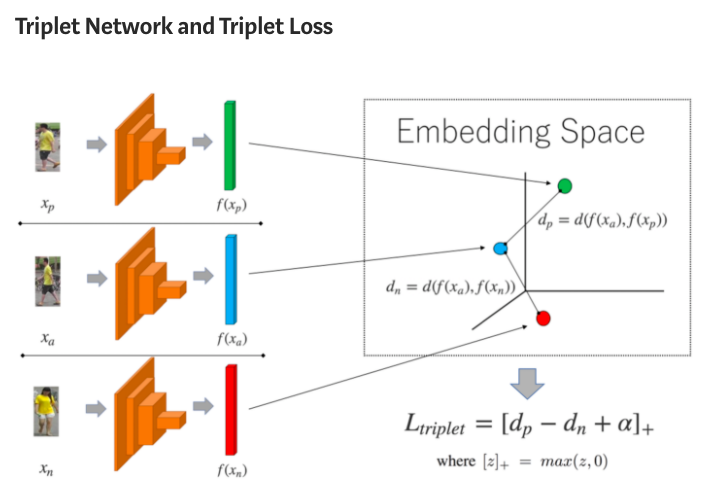

Credit: [Schroff et al.](https://arxiv.org/abs/1503.03832) 

In [9]:
def siamese_network(model_type='simple', input_shape=(28, 28, 1)):

  if model_type.lower() == 'simple':
    embedding_model = simple_model(input_shape)
  elif model_type.lower() == 'inception':
    embedding_model = facenet_model(input_shape)
  else:
    print("Kindly pass model type either 'SIMPLE' or 'INCEPTION'.")
    return
    
  input_anchor = tf.keras.layers.Input(shape=input_shape)
  input_positive = tf.keras.layers.Input(shape=input_shape)
  input_negative = tf.keras.layers.Input(shape=input_shape)

  # Generating embedding for anchor, positive and negative data points.
  emb_anchor = embedding_model(input_anchor)
  emb_positive = embedding_model(input_positive)
  emb_negative = embedding_model(input_negative)

  output = tf.keras.layers.concatenate([emb_anchor, emb_positive, emb_negative], axis=1)

  net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
  net.summary()
  return net



### Triplet Loss

Author of Facenet research paper has used following equation for triplet loss:

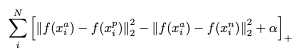

In [10]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
  anchor, pos, neg = y_pred[0], y_pred[1], y_pred[2]
  pos_dist = tf.reduce_sum(tf.square(anchor - pos), axis=-1)
  neg_dist = tf.reduce_sum(tf.square(anchor - neg), axis=-1)
  loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
  return tf.reduce_sum(tf.maximum(loss, 0))

### Data Generator

In [11]:
# We're using Data Generator to avoid loading all data at once. 
def data_generator(batch_size=256):
  while True:
    x = create_batch(batch_size)
    y = np.zeros((batch_size, 3*emb_size))
    yield x, y

### Loading Model

In [12]:
network = siamese_network('simple', (28, 28, 1))

Model: "simple_facenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 30, 30, 1)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 12, 12, 64)        3200      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 12, 12, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 12, 12, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)           

In [13]:
epochs = 30
batch_size = 2048
steps_per_epoch = int(x_train.shape[0]/batch_size)

# Model Compiling - Defining optimizer and our custom loss function - triplet loss
network.compile(optimizer='adam', loss=triplet_loss)

# Model Fit
history  = network.fit(
    data_generator(batch_size),
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    verbose=True
)

Epoch 1/30
29/29 [==============================] - 25s 865ms/step - loss: 37.8633
Epoch 2/30
29/29 [==============================] - 26s 893ms/step - loss: 20.1390
Epoch 3/30
29/29 [==============================] - 26s 900ms/step - loss: 19.4905
Epoch 4/30
29/29 [==============================] - 26s 892ms/step - loss: 18.8952
Epoch 5/30
29/29 [==============================] - 26s 891ms/step - loss: 9.3529
Epoch 6/30
29/29 [==============================] - 26s 899ms/step - loss: 8.7942
Epoch 7/30
29/29 [==============================] - 26s 884ms/step - loss: 5.6985
Epoch 8/30
29/29 [==============================] - 26s 890ms/step - loss: 5.8312
Epoch 9/30
29/29 [==============================] - 26s 890ms/step - loss: 9.7546
Epoch 10/30
29/29 [==============================] - 26s 890ms/step - loss: 7.8716
Epoch 11/30
29/29 [==============================] - 26s 896ms/step - loss: 5.6591
Epoch 12/30
29/29 [==============================] - 26s 888ms/step - loss: 2.9856
Epoch 13/

### Inception Model

In [12]:
inception_network = siamese_network('inception', (28, 28, 1))

Model: "FaceRecoModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 30, 30, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 13, 13, 64)   1664        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 13, 13, 64)   256         Conv1[0][0]                      
______________________________________________________________________________________

In [13]:
epochs = 30
batch_size = 2048
steps_per_epoch = int(x_train.shape[0]/batch_size)

# Model Compiling - Defining optimizer and our custom loss function - triplet loss
inception_network.compile(optimizer='adam', loss=triplet_loss)

# Model Fit
inception_history  = inception_network.fit(
    data_generator(batch_size),
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    verbose=True
)


Epoch 1/30
29/29 [==============================] - 26s 888ms/step - loss: 9.4689
Epoch 2/30
29/29 [==============================] - 27s 917ms/step - loss: 10.1393
Epoch 3/30
29/29 [==============================] - 27s 918ms/step - loss: 22.3169
Epoch 4/30
29/29 [==============================] - 26s 909ms/step - loss: 9.4067
Epoch 5/30
29/29 [==============================] - 27s 920ms/step - loss: 7.8605
Epoch 6/30
29/29 [==============================] - 27s 921ms/step - loss: 11.7435
Epoch 7/30
29/29 [==============================] - 26s 910ms/step - loss: 9.4666
Epoch 8/30
29/29 [==============================] - 26s 912ms/step - loss: 8.9433
Epoch 9/30
29/29 [==============================] - 27s 932ms/step - loss: 6.5947
Epoch 10/30
29/29 [==============================] - 27s 927ms/step - loss: 7.8477
Epoch 11/30
29/29 [==============================] - 27s 925ms/step - loss: 6.5160
Epoch 12/30
29/29 [==============================] - 27s 926ms/step - loss: 4.0823
Epoch 13/3

### Performance and T-SNE Embedding

In [15]:
def tsne_embeddings(Pred, Label):
  tsne = TSNE(n_components=2, n_iter=600, perplexity=50, verbose=1) 
  X_2d = tsne.fit_transform(Pred)
  df_tsne = pd.DataFrame(X_2d, columns=['comp1', 'comp2'])
  df_tsne['label'] = Label
  sns.lmplot(x='comp1', y='comp2', hue='label', data=df_tsne, fit_reg=False)
  

def learning_curve(hist_obj, title):
  hist = pd.DataFrame(hist_obj.history)
  plt.figure(figsize=(10, 6))
  plt.plot(hist)
  plt.xlabel('Epoches ------>')
  plt.ylabel('Loss ------>')
  plt.title(title)
  

#### Simple Model

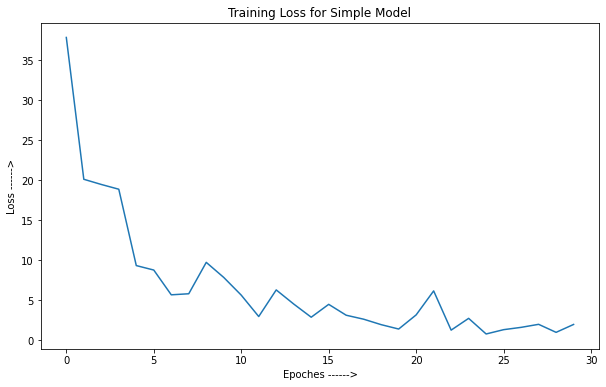

In [17]:
learning_curve(history, 'Training Loss for Simple Model')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.137s...
[t-SNE] Computed neighbors for 10000 samples in 25.536s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.330783
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.726875
[t-SNE] KL divergence after 600 iterations: 2.483131


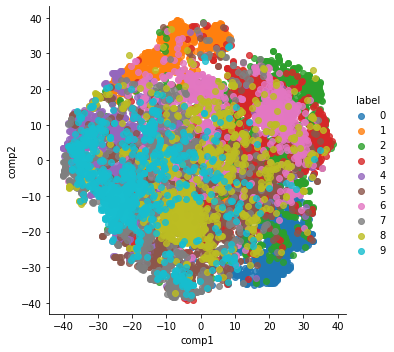

In [18]:
dummy = np.zeros(x_test.shape)
test_pred = network.predict((x_test, dummy, dummy))[:,:emb_size]

# checking tsne embedding
tsne_embeddings(test_pred, y_test)


#### Inception Model

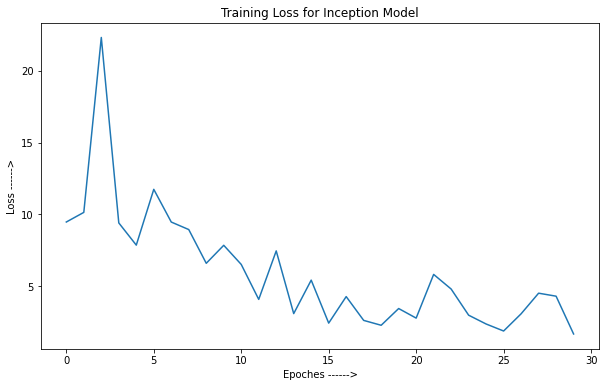

In [16]:
learning_curve(inception_history, 'Training Loss for Inception Model')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.140s...
[t-SNE] Computed neighbors for 10000 samples in 26.174s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.590329
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.097366
[t-SNE] KL divergence after 600 iterations: 2.421142


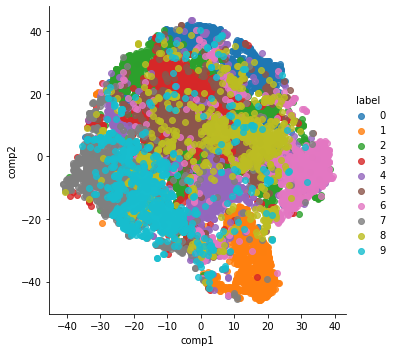

In [17]:
dummy = np.zeros(x_test.shape)
inc_test_pred = inception_network.predict((x_test, dummy, dummy))[:,:emb_size]

# checking tsne embedding
tsne_embeddings(inc_test_pred, y_test)

Interpretation:
* Training loss of inception model is more or less similar to our simple model implementation.
* Despite that, we are having better cluster as you compare t-SNE plots of both models.
* 4, 7 and 9 are making separate clusters in case of inception model but in simple model, they are overlapping too much.
